## Cahier des Charges

### Phase 1 : Exploration et Preparation des Donnees

#### 1.1 Chargement et exploration

- Charger le dataset

In [181]:
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import joblib
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

In [125]:
DIR_FILE = Path.cwd()

csv_file_path = DIR_FILE / "telco_customer_churn.csv"
df = pd.read_csv(csv_file_path)

- Afficher les dimensions et types de donnees

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [127]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [128]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

- Identifier les valeurs manquantes

In [129]:
df_clean = df.drop("customerID", axis=1)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

In [130]:
def analyse_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isna().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame(
        {
            "Colonnes": missing.index,
            "Valeurs manquantes": missing.values,
            "Pourcentages": missing_pct.values,
        }
    )
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values(
        "Pourcentages", ascending=False
    )
    return df_missing


missing_data = analyse_missing_date(df_clean)
if len(missing_data) > 0:
    print(missing_data.head(len(missing_data)))
else:
    print("Pas de valeur manquante")

        Colonnes  Valeurs manquantes  Pourcentages
18  TotalCharges                  11      0.156183


- Analyser la distribution de la variable cible (Churn)

Text(0, 0.5, 'Nombre de clients')

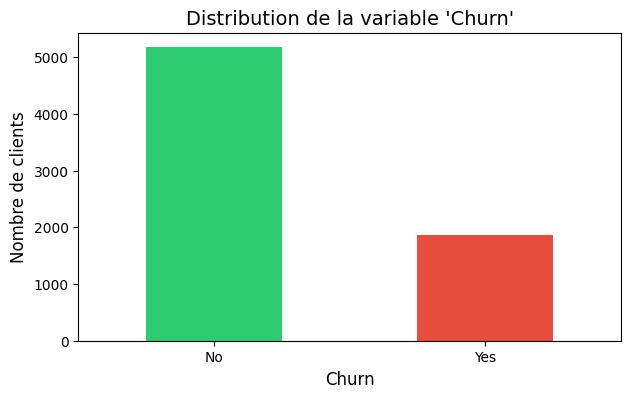

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
df_clean["Churn"].value_counts().plot(
    kind="bar", color=["#2ECC71", "#E74C3C"], rot=0, ax=ax
)
ax.set_title("Distribution de la variable 'Churn'", fontsize=14)
ax.set_xlabel("Churn", fontsize=12)
ax.set_ylabel("Nombre de clients", fontsize=12)

#### 1.2 Analyse exploratoire

- Statistiques descriptives des variables numeriques

In [132]:
num_columns = df_clean.select_dtypes(include=np.number).columns.to_list()
print("Numeric columns: ", num_columns)

Numeric columns:  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [133]:
df_num = df_clean[num_columns]
df_num.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


- Distribution des variables categoriques

In [134]:
cat_columns = df_clean.select_dtypes(include="object").columns.to_list()
print("Categorical columns: ", cat_columns)

Categorical columns:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


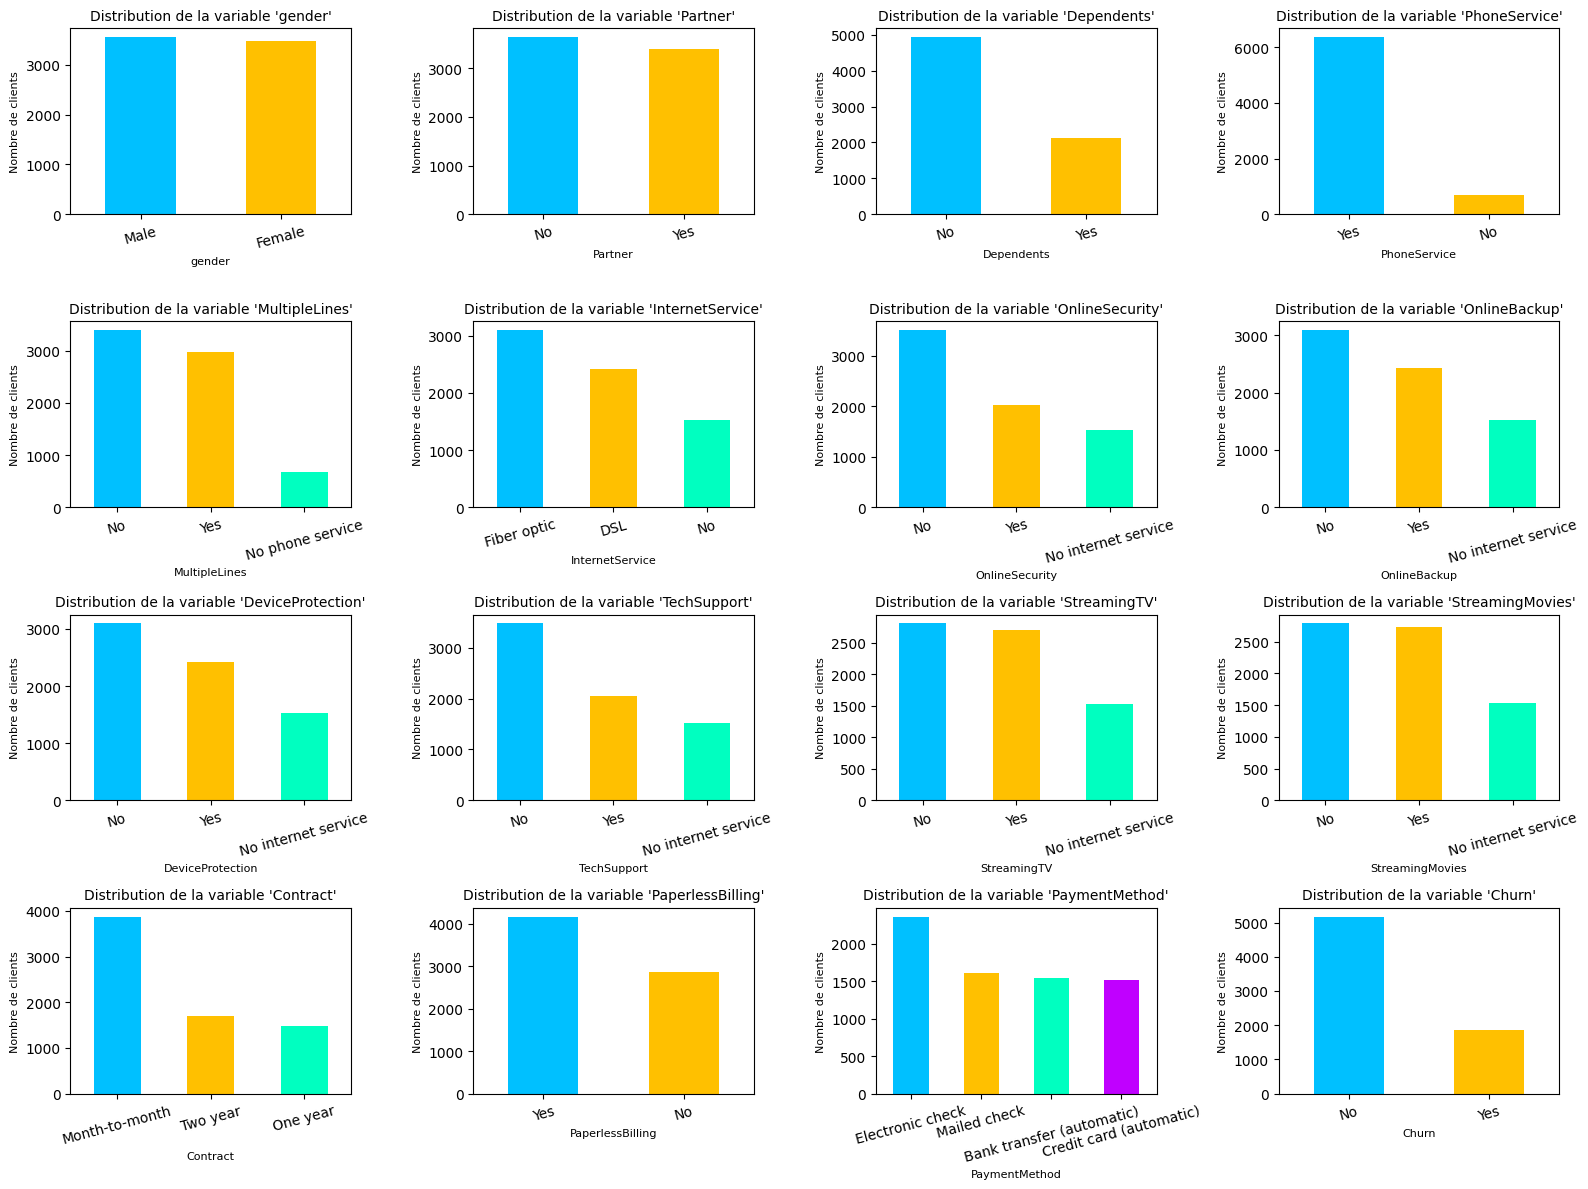

In [135]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

for k, feature in enumerate(cat_columns):
    ax = axes[k // 4, k % 4]
    df_clean[feature].value_counts().plot(
        kind="bar", color=["#00C0FF", "#FFC000", "#00FFC0", "#C000FF"], rot=15, ax=ax
    )
    ax.set_title(f"Distribution de la variable '{feature}'", fontsize=10)
    ax.set_xlabel(feature, fontsize=8)
    ax.set_ylabel("Nombre de clients", fontsize=8)

plt.tight_layout()

- Correlation entre variables numeriques

In [136]:
df_corr = df_clean[num_columns].copy()
corr_mat = df_corr.corr()

print(corr_mat)

                SeniorCitizen    tenure  MonthlyCharges  TotalCharges
SeniorCitizen        1.000000  0.016567        0.220173      0.102411
tenure               0.016567  1.000000        0.247900      0.825880
MonthlyCharges       0.220173  0.247900        1.000000      0.651065
TotalCharges         0.102411  0.825880        0.651065      1.000000


In [137]:
def find_strong_correlations(
    corr_mat: pd.DataFrame, threshold: float = 0.5
) -> pd.DataFrame:
    pair = []
    cols = corr_mat.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r = corr_mat.iloc[i, j]
            if abs(r) >= threshold:
                pair.append(
                    {
                        "Variable_1": cols[i],
                        "Variable_2": cols[j],
                        "Corrélation": round(r, 3),
                    }
                )
    results = pd.DataFrame(pair)
    results_sorted = results.sort_values(
        "Corrélation",
        ascending=False,
        key=abs,
    )
    return results_sorted


strong_corr = find_strong_correlations(corr_mat, threshold=0.5)
strong_corr.head(20)

,Variable_1,Variable_2,Corrélation
0,tenure,TotalCharges,0.826
1,MonthlyCharges,TotalCharges,0.651


- Taux de churn par segment (contrat, anciennete, etc.)

Text(0, 0.5, 'Moyenne tenure')

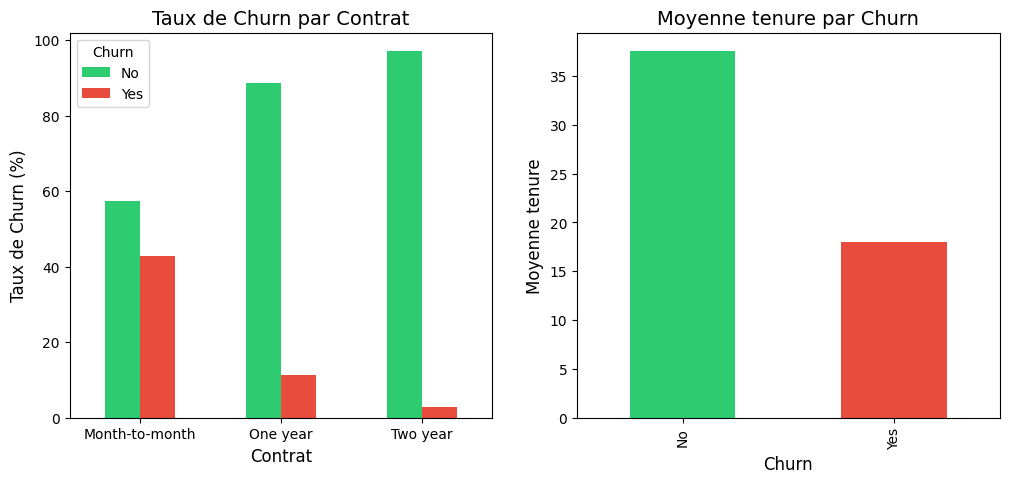

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
contract_churn = df_clean.groupby(["Contract", "Churn"])["Churn"].size().unstack()
contract_churn = contract_churn.div(contract_churn.sum(axis=1), axis=0) * 100
contract_churn.plot(kind="bar", color=["#2ECC71", "#E74C3C"], rot=0, ax=ax1)
ax1.set_title("Taux de Churn par Contrat", fontsize=14)
ax1.set_xlabel("Contrat", fontsize=12)
ax1.set_ylabel("Taux de Churn (%)", fontsize=12)

ax2 = axes[1]
education_class = df_clean.groupby("Churn")["tenure"].mean().sort_index()
education_class.plot(kind="bar", color=["#2ECC71", "#E74C3C"], ax=ax2)
ax2.set_title("Moyenne tenure par Churn", fontsize=14)
ax2.set_xlabel("Churn", fontsize=12)
ax2.set_ylabel("Moyenne tenure", fontsize=12)

#### 1.3 Visualisations

- Histogrammes des variables numeriques

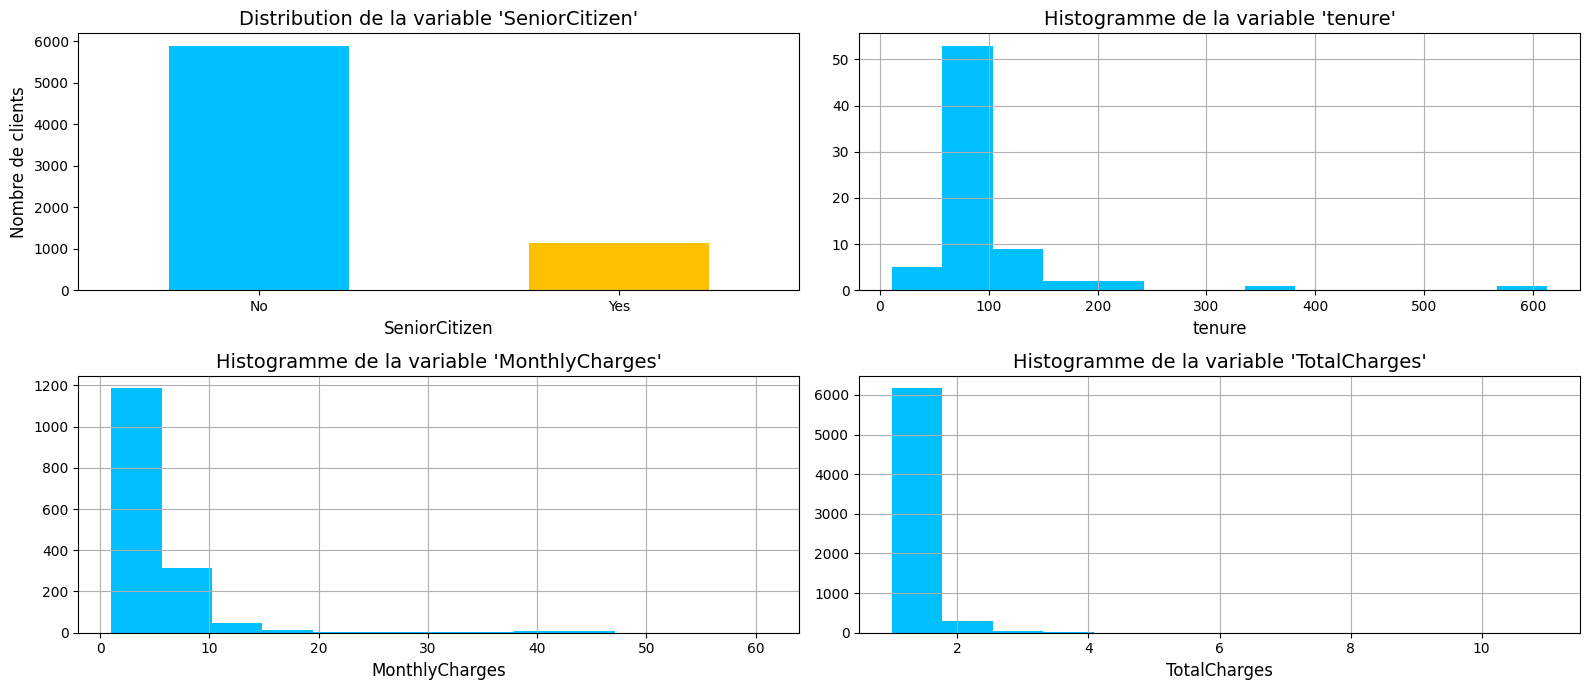

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7))

ax1 = axes[0, 0]
df_clean["SeniorCitizen"].value_counts().plot(
    kind="bar", color=["#00C0FF", "#FFC000"], rot=0, ax=ax1
)
ax1.set_title("Distribution de la variable 'SeniorCitizen'", fontsize=14)
ax1.set_xlabel("SeniorCitizen", fontsize=12)
ax1.set_ylabel("Nombre de clients", fontsize=12)
ax1.set_xticklabels(labels=["No", "Yes"])

ax2 = axes[0, 1]
df_clean["tenure"].value_counts().hist(
    bins=int(1 + np.log2(len(df["tenure"]))), color=["#00C0FF"], ax=ax2
)
ax2.set_title("Histogramme de la variable 'tenure'", fontsize=14)
ax2.set_xlabel("tenure", fontsize=12)

ax3 = axes[1, 0]
df_clean["MonthlyCharges"].value_counts().hist(
    bins=int(1 + np.log2(len(df["MonthlyCharges"]))), color=["#00C0FF"], ax=ax3
)
ax3.set_title("Histogramme de la variable 'MonthlyCharges'", fontsize=14)
ax3.set_xlabel("MonthlyCharges", fontsize=12)

ax4 = axes[1, 1]
df_clean["TotalCharges"].value_counts().hist(
    bins=int(1 + np.log2(len(df["TotalCharges"]))), color=["#00C0FF"], ax=ax4
)
ax4.set_title("Histogramme de la variable 'TotalCharges'", fontsize=14)
ax4.set_xlabel("TotalCharges", fontsize=12)

plt.tight_layout()

- Bar plots du taux de churn par categorie

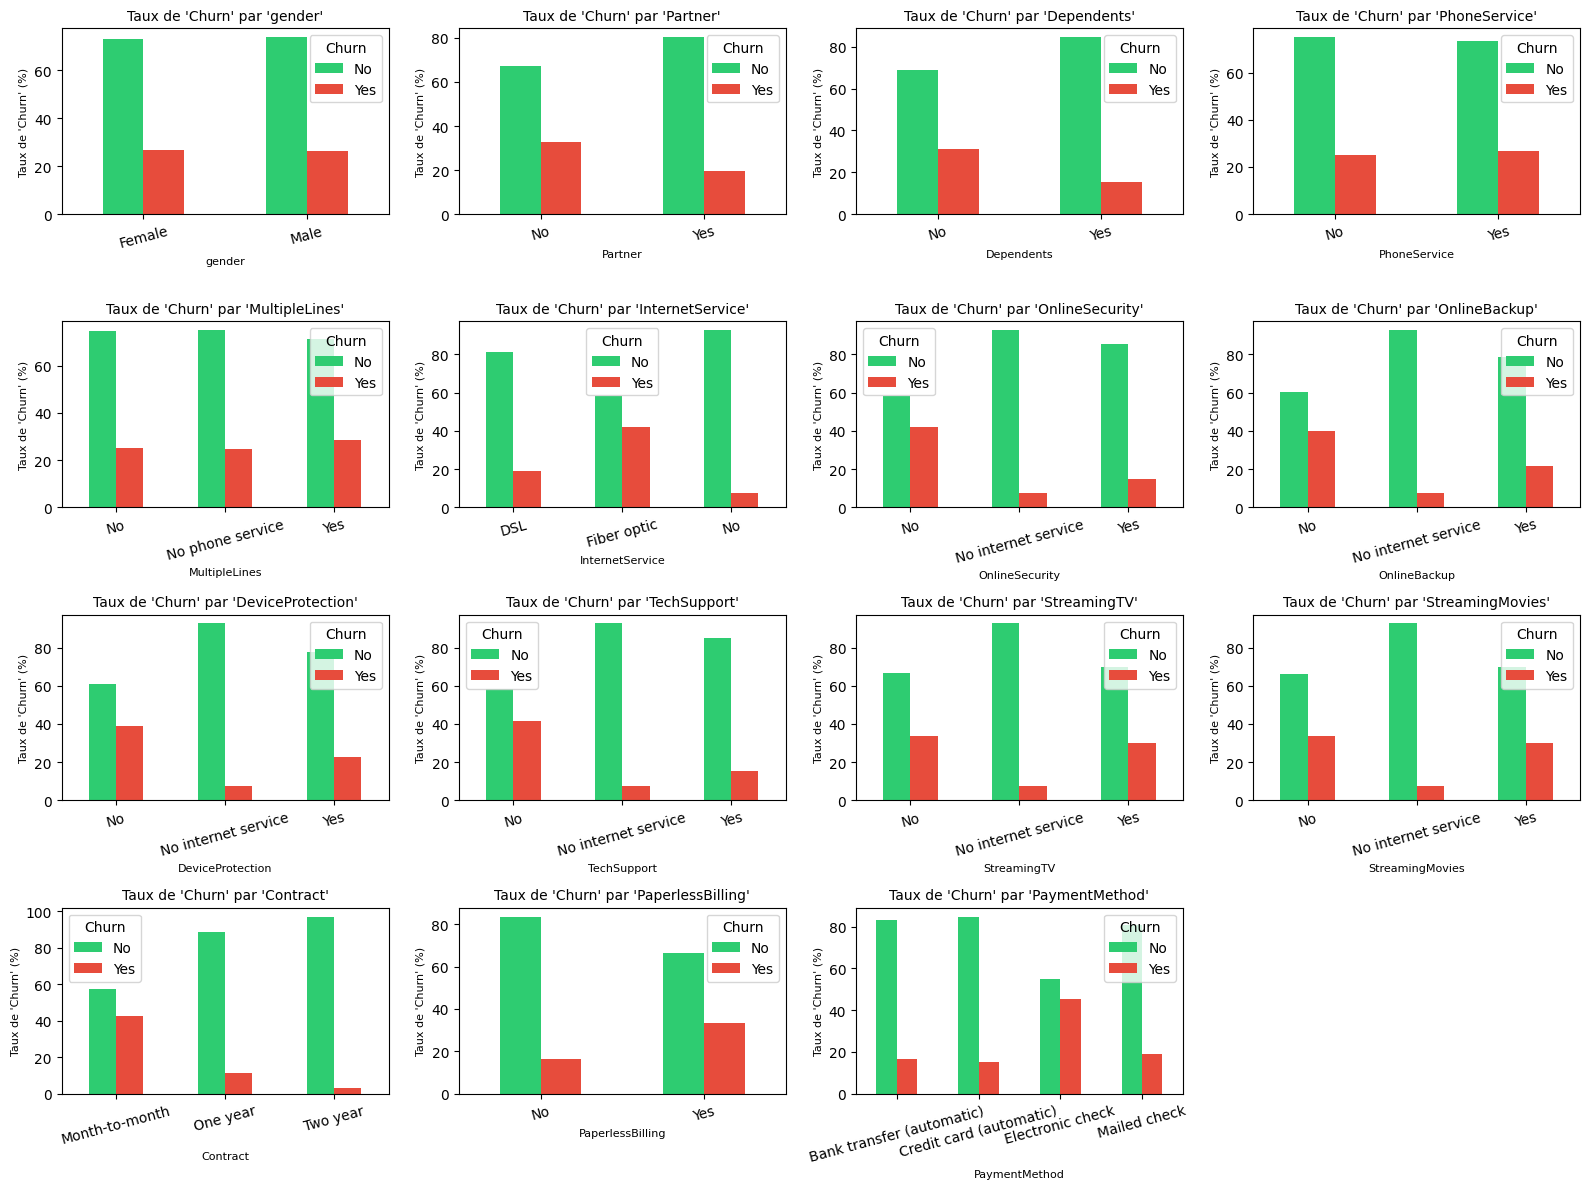

In [140]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

for k, feature in enumerate(cat_columns):
    ax = axes[k // 4, k % 4]
    if feature != "Churn":
        feature_churn = df_clean.groupby([feature, "Churn"])["Churn"].size().unstack()
        feature_churn = feature_churn.div(feature_churn.sum(axis=1), axis=0) * 100
        feature_churn.plot(kind="bar", color=["#2ECC71", "#E74C3C"], rot=15, ax=ax)
        ax.set_title(f"Taux de 'Churn' par '{feature}'", fontsize=10)
        ax.set_xlabel(feature, fontsize=8)
        ax.set_ylabel("Taux de 'Churn' (%)", fontsize=8)
    else:
        ax.set_axis_off()

plt.tight_layout()

- Heatmap de correlation

<Axes: title={'center': 'Matrice de corrélation - Variables numériques'}>

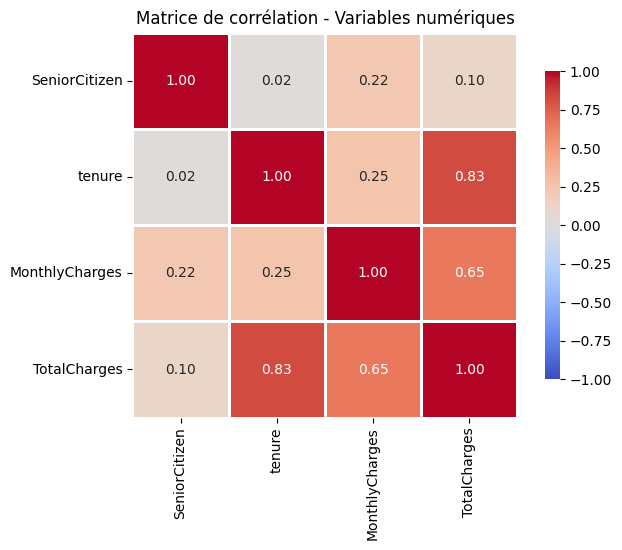

In [141]:
plt.figure(figsize=(7, 5))
plt.title("Matrice de corrélation - Variables numériques")

sns.heatmap(
    corr_mat,
    annot=True,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
)

#### 1.4 Preparation des donnees

- Traitement des valeurs manquantes
- Encodage des variables categoriques
- Separation train/test (stratifiee)
- Normalisation si necessaire

In [142]:
X = df_clean.drop("Churn", axis=1)
y = df_clean["Churn"].copy()

num_features = X.select_dtypes(include=np.number).columns.to_list()
cat_features = X.select_dtypes(include="object").columns.to_list()

In [143]:
num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="error")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ]
)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Phase 2 : Modelisation

#### 2.1 Baseline

- Entrainer un modele simple (Logistic Regression)

In [145]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression()),
    ]
)

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression())])

- Etablir les metriques de reference

In [146]:
y_pred_train_lr = lr_pipeline.predict(X_train)
y_pred_test_lr = lr_pipeline.predict(X_test)

print("Accuracy Train: ", accuracy_score(y_train, y_pred_train_lr))
print("Accuracy Test: ", accuracy_score(y_test, y_pred_test_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_test_lr))

Accuracy Train:  0.8059992900248492
Accuracy Test:  0.8055358410220014
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



#### 2.2 Comparaison d'algorithmes

Tester au minimum :

- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- KNN

Pour chaque modele :

- Metriques : Accuracy, Precision, Recall, F1

In [147]:
models = {
    "lr": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression()),
        ]
    ),
    "dt": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", DecisionTreeClassifier(random_state=42)),
        ]
    ),
    "rf": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(random_state=42)),
        ]
    ),
    "gb": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", GradientBoostingClassifier(random_state=42)),
        ]
    ),
    "knn": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", KNeighborsClassifier()),
        ]
    ),
}

In [148]:
def compute_model_comparison(models: dict[str, Pipeline]) -> tuple[pd.DataFrame, dict[str, np.ndarray]]:
    results = []
    predictions = {}

    for name, pipeline in models.items():
        t0 = time.time()
        pipeline.fit(X_train, y_train)
        t1 = time.time()
        y_pred = pipeline.predict(X_test)
        predictions[name] = y_pred

        results.append(
            {
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1-Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
                "Execution_time": t1 - t0,
            }
        )
    
    return pd.DataFrame(results), predictions

df_results, predictions = compute_model_comparison(models)

#### 2.3 Selection du meilleur modele

- Tableau comparatif des performances
- Choix du modele base sur les criteres metier (recall important)

In [149]:
df_results.sort_values("Recall", ascending=False, inplace=True)
df_results.head()

,Model,Accuracy,Precision,Recall,F1-Score,Execution_time
3,gb,0.806246,0.796394,0.806246,0.797889,0.833892
0,lr,0.805536,0.797924,0.805536,0.800228,0.050227
2,rf,0.777857,0.765484,0.777857,0.768824,0.448257
4,knn,0.763662,0.766765,0.763662,0.765123,0.023781
1,dt,0.728886,0.731692,0.728886,0.730236,0.047921


Les deux meilleurs modèles sont LogisticRegression et GradientBoost. Le temps d'éxécution du modèle LogisticRegression étant bien inférieur que celui du modèle GradientBoost, on sélectionnera le modèle LogisticRegression dans la suite de l'étude.

### 3 Feature importance

- Analyser l'importance des features

In [154]:
lr_clf = lr_pipeline.named_steps["classifier"]
preprocessor_fit = lr_pipeline.named_steps["preprocessor"]

ohe = preprocessor_fit.named_transformers_["cat"].named_steps["encoder"]
cat_features_names = ohe.get_feature_names_out(cat_features).tolist()
all_features = cat_features_names + num_features

lr_coef = lr_clf.coef_[0,:]
indices = np.argsort(lr_coef)[::-1]

sorted_names = [all_features[i] for i in indices]
sorted_coef = lr_coef[indices]

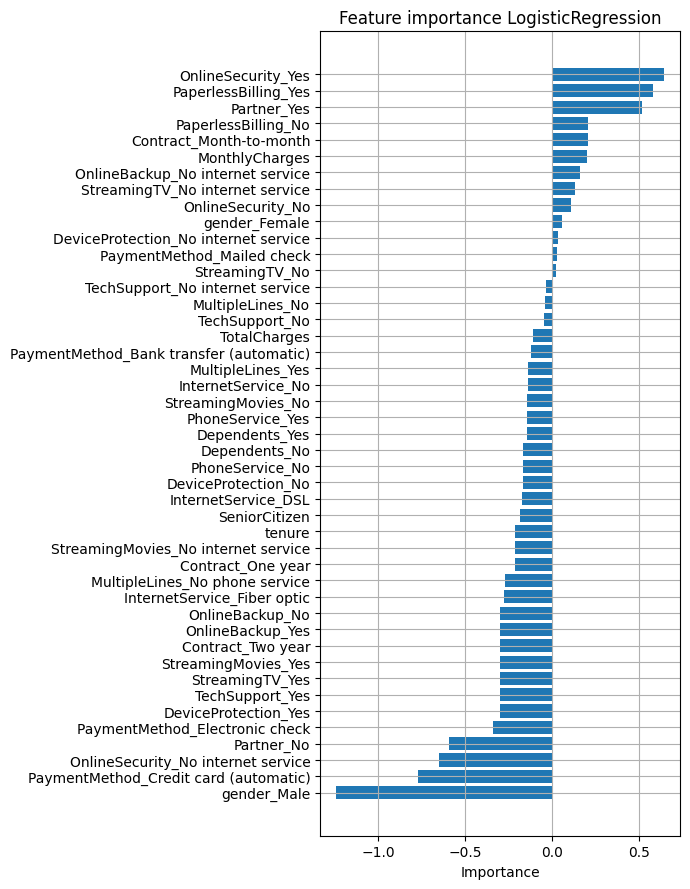

In [155]:
fig, axes = plt.subplots(1,1,figsize=(7,9))

axes.barh(range(len(sorted_coef)), sorted_coef[::-1])
axes.set_yticks(range(len(sorted_coef)))
axes.set_yticklabels(sorted_names[::-1], fontsize=10)
axes.set_xlabel("Importance", fontsize=10)
axes.set_title("Feature importance LogisticRegression")
axes.grid(visible=True)

plt.tight_layout()

- Identifier les 5 features les plus predictives

In [164]:
indices_abs = np.argsort(np.abs(lr_coef))[::-1]
sorted_names_abs = [all_features[i] for i in indices_abs]
sorted_coef_abs = lr_coef[indices_abs]

print(sorted_names_abs[:7])

['gender_Male', 'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'Partner_No', 'PaperlessBilling_Yes', 'Partner_Yes']


- Tester un modele avec seulement ces features

In [169]:
X2 = df_clean[["gender", "PaymentMethod", "OnlineSecurity", "Partner", "PaperlessBilling"]].copy()

num_features2 = X2.select_dtypes(include=np.number).columns.to_list()
cat_features2 = X2.select_dtypes(include="object").columns.to_list()

In [170]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.2, random_state=42, stratify=y
)

In [172]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features2),
        ("cat", cat_pipeline, cat_features2),
    ]
)

lr_pipeline2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor2),
        ("classifier", LogisticRegression()),
    ]
)

lr_pipeline2.fit(X_train2, y_train2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'PaymentMethod',
                                                   'OnlineSecurity', 'Partner',
                                                   'PaperlessBilling'])])),
                ('classifier', LogisticRegression())])

In [173]:
y_pred_train_lr2 = lr_pipeline2.predict(X_train2)
y_pred_test_lr2 = lr_pipeline2.predict(X_test2)

print("Accuracy Train: ", accuracy_score(y_train2, y_pred_train_lr2))
print("Accuracy Test: ", accuracy_score(y_test2, y_pred_test_lr2))
print("Classification Report:")
print(classification_report(y_test2, y_pred_test_lr2))

Accuracy Train:  0.7619808306709265
Accuracy Test:  0.7608232789212207
Classification Report:
              precision    recall  f1-score   support

          No       0.78      0.94      0.85      1035
         Yes       0.61      0.26      0.37       374

    accuracy                           0.76      1409
   macro avg       0.70      0.60      0.61      1409
weighted avg       0.74      0.76      0.72      1409



### Phase 4 : Mise en Production

#### 4.1 Pipeline final

- Creer un pipeline sklearn complet
- Inclure preprocessing + modele

In [179]:
class Production:
    def __init__(self, df: pd.DataFrame, target: str):
        self.X = df.drop(target, axis=1)
        self.y = df[target].copy()
        self.num_features = X.select_dtypes(include=np.number).columns.to_list()
        self.cat_features = X.select_dtypes(include="object").columns.to_list()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        self.num_pipeline = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        self.cat_pipeline = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="error")),
            ]
        )
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("num", num_pipeline, num_features),
                ("cat", cat_pipeline, cat_features),
            ]
        )
        self.clf_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", LogisticRegression()),
            ]
        )
        self.clf_pipeline.fit(X_train, y_train)
        self.y_pred = self.clf_pipeline.predict(X_test)

prod = Production(df_clean, "Churn")
print("Accuracy: ", accuracy_score(prod.y_test, prod.y_pred))
print("Accuracy: ", classification_report(prod.y_test, prod.y_pred))

Accuracy:  0.8055358410220014
Accuracy:                precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



#### 5.2 Sauvegarde du modele

- Sauvegarder avec joblib

In [182]:
joblib.dump(prod.clf_pipeline, 'tp_final.pkl')

['tp_final.pkl']

#### 5.3 Fonction de prediction

In [189]:
def predict_churn(customer_data):
    """
    Predit le risque de churn pour un client.

    Args:
        customer_data: dict avec les caracteristiques du client

    Returns:
        dict avec probabilite de churn et recommandation
    """
    return prod.clf_pipeline.predict(pd.DataFrame({key: [value] for key, value in customer_data.items()}))

new_customer = {
    "customerID": "7590-VHVEG",
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85,
}

print("Prediction: ", predict_churn(new_customer))

Prediction:  ['Yes']
